License

```
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
```

# Using CompilerGym environments with RLlib

In this notebook we will use [RLlib](https://docs.ray.io/en/master/rllib.html) to train an agent for CompilerGym's [LLVM environment](https://facebookresearch.github.io/CompilerGym/llvm/index.html). RLlib is a popular library for scalable reinforcement learning, built on [Ray](https://docs.ray.io/en/master/index.html). It provides distributed implementations of several standard reinforcement learning algorithms.

Our goal is not to produce the best agent, but to demonstrate how to integrate CompilerGym with RLlib. It will take about 20 minutes to work through. Let's get started!

## Installation

We'll begin by installing the `compiler_gym` and `ray` packages:

In [58]:
!pip install compiler_gym 'ray[default,rllib]' &>/dev/null || echo "Install failed!"

# Print the versions of the libraries that we are using:
import compiler_gym
import ray

print("compiler_gym version:", compiler_gym.__version__)
print("ray version:", ray.__version__)

compiler_gym version: 0.2.3
ray version: 1.9.0


## Defining an Environment

Next we will define the environment to use for our experiments. For the purposes of a simple demo we will apply two simplifying constraints to CompilerGym's LLVM environment:

1. We will use only a small subset of the command line flag action space.
2. We will clip the length of episodes to a maximum number of steps.

To make things simple we will define a `make_env()` helper function to create our environment, and use the [compiler_gym.wrappers](https://facebookresearch.github.io/CompilerGym/compiler_gym/wrappers.html) API to implement these constraints. There is quite a lot going on in this cell, be sure to read through the comments for an explanation of what is going on!

In [59]:
import sys
import os
os.environ.setdefault("COMPILER2_ROOT", "/home/dx4/tools/compiler2")



'/home/dx4/tools/compiler2'

In [60]:
from compiler_gym.spaces import Reward
from compiler_gym.third_party import llvm
from compiler_gym.util.logging import init_logging
from compiler_gym.util.registration import register
from compiler_gym.util.runfiles_path import runfiles_path, site_data_path
from compiler_gym.service.connection import ServiceError
import compiler2_service.paths

In [61]:
from compiler_gym.envs.llvm.datasets import (
    AnghaBenchDataset,
    BlasDataset,
    CBenchDataset,
    CBenchLegacyDataset,
    CBenchLegacyDataset2,
    CHStoneDataset,
    CsmithDataset,
    NPBDataset,
)

from compiler2_service.agent_py.rewards import perf_reward, runtime_reward
from compiler2_service.agent_py.datasets import poj104_dataset, hpctoolkit_dataset


def register_env():
    register(
        id="perf-v0",
        entry_point="compiler_gym.envs:CompilerEnv",
        kwargs={
            "service": compiler2_service.paths.COMPILER2_SERVICE_PY,
            "rewards": [ perf_reward.Reward(),
                         runtime_reward.Reward()
            ],
            "datasets": [
                hpctoolkit_dataset.Dataset(),
                CBenchDataset(site_data_path("llvm-v0")),
                CsmithDataset(site_data_path("llvm-v0"), sort_order=0),
                NPBDataset(site_data_path("llvm-v0"), sort_order=0),
                BlasDataset(site_data_path("llvm-v0"), sort_order=0),
                AnghaBenchDataset(site_data_path("llvm-v0"), sort_order=0),
                CHStoneDataset(site_data_path("llvm-v0"), sort_order=0),
            ],
        },
    )

# register_env()

In [62]:
from compiler_gym.wrappers import ConstrainedCommandline, TimeLimit
from ray import tune
def make_env() -> compiler_gym.envs.CompilerEnv:
    """Make the reinforcement learning environment for this experiment."""
    # We will use LLVM as our base environment. Here we specify the observation
    # space from this paper: https://arxiv.org/pdf/2003.00671.pdf and the total
    # IR instruction count as our reward space, normalized against the
    # performance of LLVM's -Oz policy.
    
    # env = compiler_gym.make(
    #     "llvm-v0",
    #     observation_space="Autophase",
    #     reward_space="IrInstructionCountOz",
    # )

    # env = compiler_gym.make(
    #     "perf-v0",
    #     observation_space="runtime",
    #     reward_space="runtime"
    # )
    
    env = compiler2_service.make(
        "perf-v0",
        observation_space="runtime",
        reward_space="runtime"
    )

    # Here we constrain the action space of the environment to use only a
    # handful of command line flags from the full set. We do this to speed up
    # learning by pruning the action space by hand. This also limits the
    # potential improvements that the agent can achieve compared to using the
    # full action space.
    env = ConstrainedCommandline(env, flags=[
        "-break-crit-edges",
        "-early-cse-memssa",
        "-gvn-hoist",
        "-gvn",
        "-instcombine",
        "-instsimplify",
        "-jump-threading",
        "-loop-reduce",
        "-loop-rotate",
        "-loop-versioning",
        "-mem2reg",
        "-newgvn",
        "-reg2mem",
        "-simplifycfg",
        "-sroa",
    ])
    # Finally, we impose a time limit on the environment so that every episode
    # for 5 steps or fewer. This is because the environment's task is continuous
    # and no action is guaranteed to result in a terminal state. Adding a time
    # limit means we don't have to worry about learning when an agent should
    # stop, though again this limits the potential improvements that the agent
    # can achieve compared to using an unbounded maximum episode length.
    env = TimeLimit(env, max_episode_steps=5)
    return env

In [63]:
# Let's create an environment and print a few attributes just to check that we 
# have everything set up the way that we would like.
with make_env() as env:
    print("Action space:", env.action_space)
    print("Observation space:", env.observation_space)
    print("Reward space:", env.reward_space)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 

Action space: Commandline([-break-crit-edges -early-cse-memssa -gvn-hoist -gvn -instcombine -instsimplify -jump-threading -loop-reduce -loop-rotate -loop-versioning -mem2reg -newgvn -reg2mem -simplifycfg -sroa])
Observation space: Box([0.5], [2.5], (1,), float64)
Reward space: runtime


Abandoning orphan service at /dev/shm/compiler_gym_dx4/s/0330T173030-057841-15e0


## Datasets

Now that we have an environment, we will need a set of programs to train on. In CompilerGym, these programs are called *benchmarks*. CompilerGym ships with [several sets of benchmarks](https://facebookresearch.github.io/CompilerGym/llvm/index.html#datasets). Here we will take a handful of benchmarks from the `npb-v0` dataset for training. We will then further divide this set into training and validation sets. We will use `chstone-v0` as a holdout test set.

In [64]:
from itertools import islice

with make_env() as env:
  # The two datasets we will be using:
  hpc_bench = env.datasets["benchmark://hpctoolkit-cpu-v0"]
  chstone = env.datasets["chstone-v0"]

  # Each dataset has a `benchmarks()` method that returns an iterator over the
  # benchmarks within the dataset. Here we will use iterator sliceing to grab a 
  # handful of benchmarks for training and validation.
  train_benchmarks = list(islice(hpc_bench.benchmarks(), 4))
  train_benchmarks, val_benchmarks = train_benchmarks[:2], train_benchmarks[2:]
  # We will use the entire chstone-v0 dataset for testing.
  test_benchmarks = list(hpc_bench.benchmarks())

print("Number of benchmarks for training:", len(train_benchmarks))
print("Number of benchmarks for validation:", len(val_benchmarks))
print("Number of benchmarks for testing:", len(test_benchmarks))

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 

Number of benchmarks for training: 2
Number of benchmarks for validation: 2
Number of benchmarks for testing: 4


## Registering the environment with RLlib

Now that we have our environment and training benchmarks, we can register the environment for use with RLlib. To do this we will define a second `make_training_env()` helper that uses the [CycleOverBenchmarks](https://facebookresearch.github.io/CompilerGym/compiler_gym/wrappers.html#compiler_gym.wrappers.CycleOverBenchmarks) wrapper to ensure that the environment uses all of the training benchmarks. We then call `tune.register_env()`, assining the environment a name.

In [65]:
from compiler_gym.wrappers import CycleOverBenchmarks

def make_training_env(*args) -> compiler_gym.envs.CompilerEnv:
  """Make a reinforcement learning environment that cycles over the
  set of training benchmarks in use.
  """
  del args  # Unused env_config argument passed by ray
  return CycleOverBenchmarks(make_env(), train_benchmarks)

tune.register_env("compiler_gym", make_training_env)

In [50]:
# Lets cycle through a few calls to reset() to demonstrate that this environment
# selects a new benchmark for each episode.
with make_training_env() as env:
  env.reset()
  print(env.benchmark)
  env.reset()
  print(env.benchmark)
  env.reset()
  print(env.benchmark)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 


 /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2 

source_filename = "/dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark.c"


 compile: 
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt -o /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark.bc /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark.ll
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark.exe
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark.bc



 pre_run_cmd: 
[]



 run_cmd: 
/dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2/benchmark.exe


hackkk: -O0
Reward Runtime: reset
benchmark://hpctoolkit-cpu-v0/conv2d

 /dev/shm/compiler_gym_dx4/s/0330T160140-438525-cab2 

source_filename = "/dev/shm/compiler_gym_dx4/s

## Run the training loop

Now that we have the environment set up, let's run a training loop. Here will use RLlib's [Proximal Policy Optimization](https://docs.ray.io/en/master/rllib-algorithms.html#ppo) implementation, and run a very short training loop just for demonstative purposes.

In [25]:
import compiler_gym.util.runfiles_path as path

print(path.runfiles_path("."))
print(path.site_data_path("."))
print(path.cache_path("."))
print(path.transient_cache_path("."))

/home/dx4/tools/miniconda3/lib/python3.8/site-packages
/home/dx4/.local/share/compiler_gym
/home/dx4/.cache/compiler_gym
/dev/shm/compiler_gym_dx4


In [79]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

# (Re)Start the ray runtime.
if ray.is_initialized():
  ray.shutdown()
ray.init(include_dashboard=False, ignore_reinit_error=True)

tune.register_env("compiler_gym", make_training_env)

analysis = tune.run(
    PPOTrainer,
    checkpoint_at_end=True,
    stop={
        "episodes_total": 5,
    },
    config={
        "seed": 0xCC,
        "num_workers": 1,
        # Specify the environment to use, where "compiler_gym" is the name we 
        # passed to tune.register_env().
        "env": "compiler_gym",
        # Reduce the size of the batch/trajectory lengths to match our short 
        # training run.
        "rollout_fragment_length": 5,
        "train_batch_size": 5,
        "sgd_minibatch_size": 5,
    }
)

Trial name,status,loc
PPO_compiler_gym_73ef2_00000,PENDING,


(PPO pid=3268638) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(PPO pid=3268638) Is that file:  True


(PPO pid=3268638) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=3268638) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=3268638) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=3268638) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=3268638) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(PPO pid=3268638) /h

(RolloutWorker pid=3268619) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=3268619) Is that file:  True


(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/co

(RolloutWorker pid=3268619) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=3268619) Is that file:  True


(RolloutWorker pid=3268619) Using backend: pytorch
(RolloutWorker pid=3268619) ./compiler_gym-llvm-service: /lib64/libtinfo.so.5: no version information available (required by ./compiler_gym-llvm-service)


(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35 
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) source_filename = "/dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.c"
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  compile: 
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.ll
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.exe
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark

(RolloutWorker pid=3268619) 2022-03-30 18:52:39,859	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
(PPO pid=3268638) 2022-03-30 18:52:40,644	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


Trial name,status,loc
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638


(PPO pid=3268638) 2022-03-30 18:52:41,133	INFO trainable.py:124 -- Trainable.setup took 11.238 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=3268638) 2022-03-30 18:52:41,134	WARNING util.py:57 -- Install gputil for GPU system monitoring.


(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35 
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) source_filename = "/dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.c"
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  compile: 
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.ll
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.exe
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark

Trial name,status,loc
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638


(RolloutWorker pid=3268619) Reward Runtime: reset
(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.35
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) hackkk: -loop-rotate
(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.34
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -newgvn
(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.34
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -loop-rotate
(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.35
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -break-crit-edges
(RolloutWorker pid=3268619) real 

Trial name,status,loc
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638


(RolloutWorker pid=3268619) real 0.97
(RolloutWorker pid=3268619) user 0.96
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: reset
(RolloutWorker pid=3268619) real 0.99
(RolloutWorker pid=3268619) user 0.99
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
Result for PPO_compiler_gym_73ef2_00000:
  agent_timesteps_total: 5
  custom_metrics: {}
  date: 2022-03-30_18-52-49
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: 0.0
  episode_reward_min: 0.0
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: aa4d4c3364b14147bb664e64dce24f42
  hostname: ufront.cs.rice.edu
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 2.708045244216919
          entropy_coeff: 0.0
          kl: -1.975283758781643e-08
       

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638,1,8.45905,5,0,0,0,5


(RolloutWorker pid=3268619) real 0.99
(RolloutWorker pid=3268619) user 0.98
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -early-cse-memssa
(RolloutWorker pid=3268619) real 0.99
(RolloutWorker pid=3268619) user 0.98
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -loop-versioning
(RolloutWorker pid=3268619) real 0.98
(RolloutWorker pid=3268619) user 0.97
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35 
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) source_filename = "/dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.c"
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) 
(Rol

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638,2,15.6794,10,0.00505051,0.010101,0,5


(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.35
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -simplifycfg
(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.34
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -loop-rotate
(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.34
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) hackkk: -gvn
(RolloutWorker pid=3268619) real 0.35
(RolloutWorker pid=3268619) user 0.34
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  /dev/shm/compiler_gym_dx4/s/033

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638,2,15.6794,10,0.00505051,0.010101,0,5


Result for PPO_compiler_gym_73ef2_00000:
  agent_timesteps_total: 15
  custom_metrics: {}
  date: 2022-03-30_18-53-03
  done: false
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.01010101010101011
  episode_reward_mean: 0.0033670033670033703
  episode_reward_min: 0.0
  episodes_this_iter: 1
  episodes_total: 3
  experiment_id: aa4d4c3364b14147bb664e64dce24f42
  hostname: ufront.cs.rice.edu
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.05000000074505806
          cur_lr: 4.999999873689376e-05
          entropy: 2.705101490020752
          entropy_coeff: 0.0
          kl: 0.0002631880925036967
          model: {}
          policy_loss: 4.688294211518951e-06
          total_loss: 2.5937080863513984e-05
          vf_explained_var: -1.0
          vf_loss: 8.08938239060808e-06
    num_agent_steps_sampled: 15
    num_agent_steps_trained: 15
    num_steps_sampled: 15
    num_steps_trained: 15
    num_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638,3,22.3577,15,0.003367,0.010101,0,5


(RolloutWorker pid=3268619) real 0.97
(RolloutWorker pid=3268619) user 0.97
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: update
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35 
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) source_filename = "/dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.c"
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619)  compile: 
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.ll
(RolloutWorker pid=3268619) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0330T185233-773938-6f35/benchmark.exe
(RolloutWorker pid=326861

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_73ef2_00000,RUNNING,128.42.128.60:3268638,4,29.7975,20,-5.20671e-05,0.010101,-0.0103093,5


(RolloutWorker pid=3268619) real 0.97
(RolloutWorker pid=3268619) user 0.97
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
(RolloutWorker pid=3268619) Reward Runtime: reset
(RolloutWorker pid=3268619) real 0.98
(RolloutWorker pid=3268619) user 0.97
(RolloutWorker pid=3268619) sys 0.00
(RolloutWorker pid=3268619) 
Result for PPO_compiler_gym_73ef2_00000:
  agent_timesteps_total: 25
  custom_metrics: {}
  date: 2022-03-30_18-53-17
  done: true
  episode_len_mean: 5.0
  episode_media: {}
  episode_reward_max: 0.01010101010101011
  episode_reward_mean: -4.165364990107272e-05
  episode_reward_min: -0.010309278350515474
  episodes_this_iter: 1
  episodes_total: 5
  experiment_id: aa4d4c3364b14147bb664e64dce24f42
  hostname: ufront.cs.rice.edu
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.02500000037252903
          cur_lr: 4.999999873689376e-05
          entropy: 2.6809191703796387
          entropy_c

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_compiler_gym_73ef2_00000,TERMINATED,128.42.128.60:3268638,5,36.3974,25,-4.16536e-05,0.010101,-0.0103093,5


(RolloutWorker pid=3268619) 2022-03-30 18:53:18,680	ERROR worker.py:431 -- SystemExit was raised from the worker
(RolloutWorker pid=3268619) Traceback (most recent call last):
(RolloutWorker pid=3268619)   File "python/ray/_raylet.pyx", line 618, in ray._raylet.execute_task
(RolloutWorker pid=3268619)   File "python/ray/_raylet.pyx", line 625, in ray._raylet.execute_task
(RolloutWorker pid=3268619)   File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
(RolloutWorker pid=3268619)   File "python/ray/_raylet.pyx", line 578, in ray._raylet.execute_task.function_executor
(RolloutWorker pid=3268619)   File "/home/dx4/tools/miniconda3/lib/python3.8/site-packages/ray/_private/function_manager.py", line 609, in actor_method_executor
(RolloutWorker pid=3268619)     return method(__ray_actor, *args, **kwargs)
(RolloutWorker pid=3268619)   File "/home/dx4/tools/miniconda3/lib/python3.8/site-packages/ray/util/tracing/tracing_helper.py", line 451, in _resume_span
(RolloutWorker pid=

## Evaluate the agent

After running the training loop we can create a new agent that has exploration disabled, restore it from the training checkpoint, and then use it for running inference tests.

In [74]:
agent = PPOTrainer(
    env="compiler_gym",
    config={
        "num_workers": 1,
        "seed": 0xCC,
        # For inference we disable the stocastic exploration that is used during 
        # training.
        "explore": False,
    },
)

# We only made a single checkpoint at the end of training, so restore that. In
# practice we may have many checkpoints that we will select from using 
# performance on the validation set.
checkpoint = analysis.get_best_checkpoint(
    metric="episode_reward_mean", 
    mode="max", 
    trial=analysis.trials[0]
)

agent.restore(checkpoint)

(RolloutWorker pid=3261324) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=3261324) Is that file:  True


(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/co

(RolloutWorker pid=3261324) What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
(RolloutWorker pid=3261324) Is that file:  True


(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/co

(RolloutWorker pid=3261324) 
(RolloutWorker pid=3261324)  /dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35 
(RolloutWorker pid=3261324) 
(RolloutWorker pid=3261324) source_filename = "/dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35/benchmark.c"
(RolloutWorker pid=3261324) 
(RolloutWorker pid=3261324) 
(RolloutWorker pid=3261324)  compile: 
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt -o /dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35/benchmark.bc /dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35/benchmark.ll
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35/benchmark.exe
(RolloutWorker pid=3261324) /home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0330T184713-557465-6f35/benchmark

(RolloutWorker pid=3261324) 2022-03-30 18:47:19,601	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2022-03-30 18:47:20,805	INFO trainable.py:124 -- Trainable.setup took 10.470 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-03-30 18:47:20,806	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-30 18:47:20,860	INFO trainable.py:467 -- Restored on 128.42.128.60 from checkpoint: /home/dx4/ray_results/PPO_2022-03-30_18-46-01/PPO_compiler_gym_8e3db_00000_0_2022-03-30_18-46-01/checkpoint_000005/checkpoint-5
2022-03-30 18:47:20,861	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': 0, '_time_total': 36.85162281990051, '_episodes_total': 5}


In [75]:
# Lets define a helper function to make it easy to evaluate the agent's 
# performance on a set of benchmarks.

def run_agent_on_benchmarks(benchmarks):
  """Run agent on a list of benchmarks and return a list of cumulative rewards."""
  with make_env() as env:
    rewards = []
    for i, benchmark in enumerate(benchmarks, start=1):
        observation, done = env.reset(benchmark=benchmark), False
        while not done:
            action = agent.compute_action(observation)
            observation, _, done, _ = env.step(action)
        rewards.append(env.episode_reward)
        print(f"[{i}/{len(benchmarks)}] {env.state}")

  return rewards

# Evaluate agent performance on the validation set.
val_rewards = run_agent_on_benchmarks(val_benchmarks)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 


 /dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b 

source_filename = "/dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark.c"


 compile: 
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt -o /dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark.bc /dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark.ll
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark.exe
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark.bc



 pre_run_cmd: 
[]



 run_cmd: 
/dev/shm/compiler_gym_dx4/s/0330T184729-604301-659b/benchmark.exe


hackkk: -O0
real 0.05
user 0.00
sys 0.00

Reward Runtime: reset
real 0.05
user 0.00
sys 0.00

hackkk: -loop-reduce
real 0.05
user 0.00
sys 0.00

Reward Runtime: update
hackk

/home/dx4/tools/miniconda3/lib/python3.8/site-packages/compiler_gym_compiler2-0.2.3-py3.8.egg/compiler2_service/agent_py/rewards/runtime_reward.py:29: RuntimeWarning: invalid value encountered in true_divide
  return float(self.baseline_runtime - observations[0]) / self.baseline_runtime


real 0.00
user 0.00
sys 0.00

Reward Runtime: update
hackkk: -loop-reduce
real 0.00
user 0.00
sys 0.00

Reward Runtime: update
hackkk: -loop-reduce
real 0.00
user 0.00
sys 0.00

Reward Runtime: update
hackkk: -loop-reduce
real 0.00
user 0.00
sys 0.00

Reward Runtime: update
[2/2] benchmark='benchmark://hpctoolkit-cpu-v0/simple_pow' commandline='opt -loop-reduce -loop-reduce -loop-reduce -loop-reduce -loop-reduce input.bc -o output.bc' walltime=0.5436251163482666 reward=nan


In [76]:
# Evaluate agent performance on the holdout test set.
test_rewards = run_agent_on_benchmarks(test_benchmarks)

What is the path /home/dx4/tools/compiler2/compiler2_service/service_py/example_service.py
Is that file:  True


/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available (required by /home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang)
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang: /lib64/libtinfo.so.5: no version information available 


 /dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36 

source_filename = "/dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark.c"


 compile: 
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/opt -o /dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark.bc /dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark.ll
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/clang /dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark.bc -lm -o /dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark.exe
/home/dx4/.local/share/compiler_gym/llvm-v0/bin/llvm-dis -o /dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark_new.ll /dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark.bc



 pre_run_cmd: 
[]



 run_cmd: 
/dev/shm/compiler_gym_dx4/s/0330T184740-307975-dc36/benchmark.exe


hackkk: -O0
real 0.96
user 0.96
sys 0.00

Reward Runtime: reset
real 0.99
user 0.98
sys 0.00

hackkk: -loop-reduce
real 0.98
user 0.97
sys 0.00

Reward Runtime: update
hackk

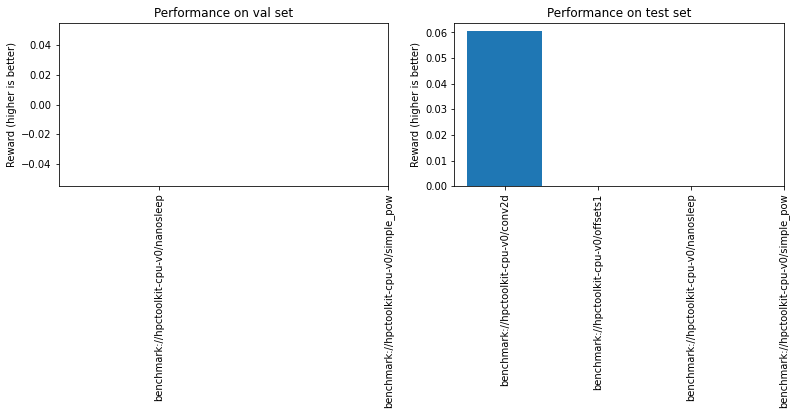

In [77]:
# Finally lets plot our results to see how we did!
from matplotlib import pyplot as plt

def plot_results(x, y, name, ax):
  plt.sca(ax)
  plt.bar(range(len(y)), y)
  plt.ylabel("Reward (higher is better)")
  plt.xticks(range(len(x)), x, rotation = 90)
  plt.title(f"Performance on {name} set")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 3)
plot_results(val_benchmarks, val_rewards, "val", ax1)
plot_results(test_benchmarks, test_rewards, "test", ax2)
plt.show()

That's it for this demonstration! Check out the [documentation site](https://facebookresearch.github.io/CompilerGym/) for more details, API reference, and more. If you can encounter any problems, please [file an issue](https://github.com/facebookresearch/CompilerGym/issues).